In [99]:
import os
import random
import shutil
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import Image

drive.mount('/content/drive')

train_path = '/content/drive/My Drive/Universidad/8vo/Apps avanzadas/Datasets posibles/Captchas/Train'
test_path = '/content/drive/My Drive/Universidad/8vo/Apps avanzadas/Datasets posibles/Captchas/Test'
val_path = '/content/drive/My Drive/Universidad/8vo/Apps avanzadas/Datasets posibles/Captchas/Validation'
dataset_path = '/content/drive/My Drive/Universidad/8vo/Apps avanzadas/Datasets posibles/Captchas/samples'

# Separar dataset a test, train y validation
if False:
  all_images = [f for f in os.listdir(dataset_dir) if f.endswith('.png')]

  random.shuffle(all_images)

  total = len(all_images)
  test_split = int(0.2 * total)
  test_images  = all_images[:test_split]
  train_images = all_images[test_split:]

  val_split = int(0.2 * len(train_images))
  val_images = train_images[:val_split]
  train_images = train_images[val_split:]

  def move_images(images, src_folder, dst_folder):
      for img in images:
          shutil.copy(os.path.join(src_folder, img), os.path.join(dst_folder, img))

  move_images(train_images, dataset_path, train_path)
  move_images(val_images, dataset_path, val_path)
  move_images(test_images, dataset_path, test_path)

  print(f"Imágenes movidas: Train={len(train_images)}, Val={len(val_images)}, Test={len(test_images)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#Importamos el dataset
IMG_SIZE = (200, 50)
def load_dataset(path, img_size=IMG_SIZE):
    X = []
    Y = []

    for filename in os.listdir(path):
      label = filename[:5]
      img = Image.open(os.path.join(path, filename)).convert('L') # Convertir a escala de grises
      X.append(np.array(img) / 255.0)
      Y.append(label)
      x, y = np.array(X), np.array(Y)
      x = x[..., np.newaxis]
    return x, y

x_train, y_train = load_dataset(train_path)
x_test, y_test = load_dataset(test_path)
x_val, y_val = load_dataset(val_path)

(50, 200, 1)


Label: gd8fb


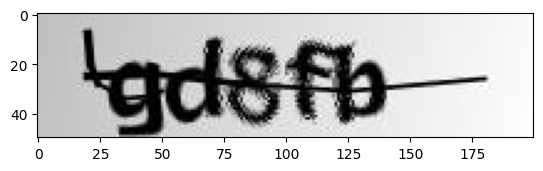

Label: n6xc5


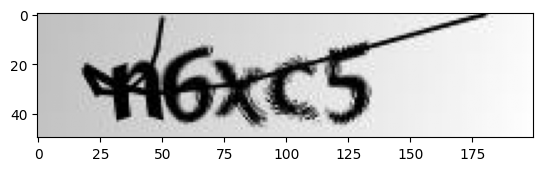

Label: 7bwm2


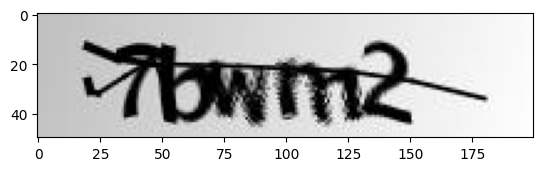

Label: 5n245


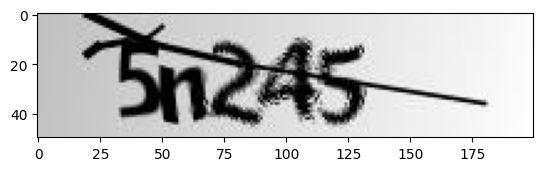

Label: b2nen


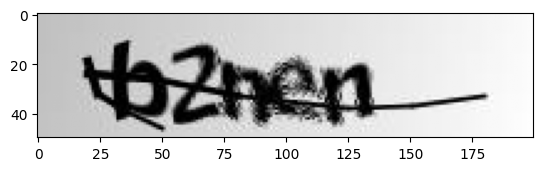

In [3]:
for i in range(5):
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    print("Label:", y_train[i])
    plt.show()

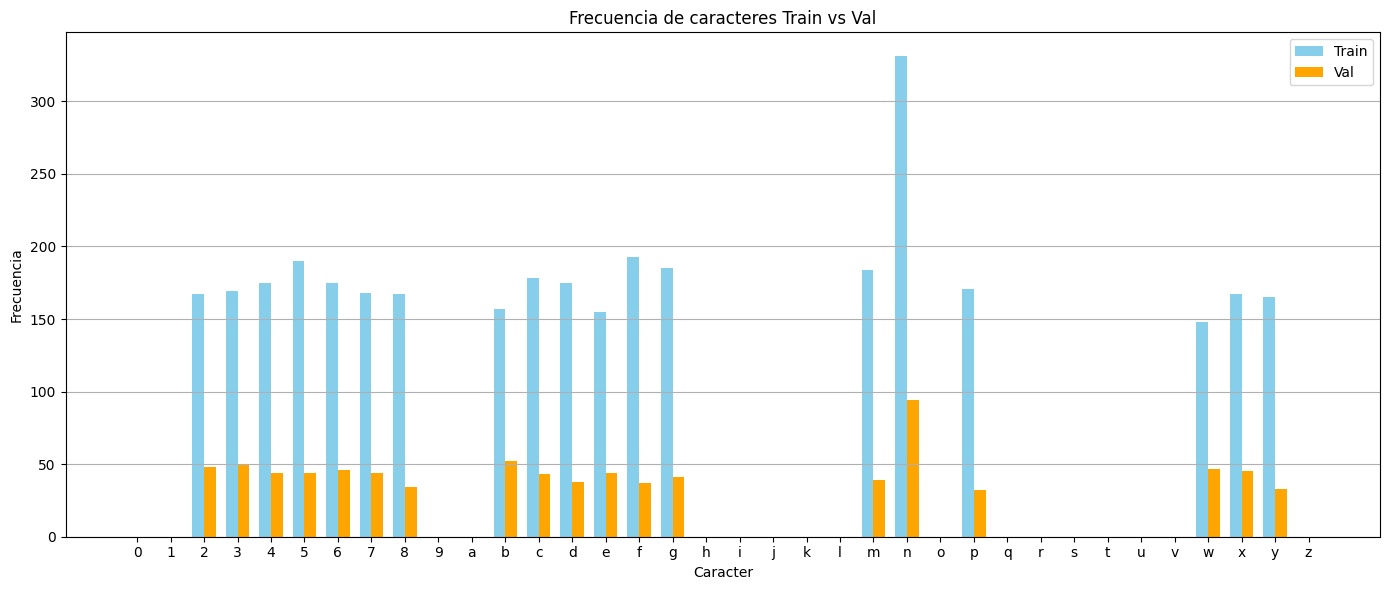

In [56]:
# Graficas frecuencia de caracteres
from collections import Counter
import string

def count_chars(labels):
  all_chars = ''.join(labels)
  char_counts = Counter(all_chars)

  return char_counts

def plot_char_frequencies(labels1, labels2, labels1_cat = 'Train', labels2_cat = 'Val', color1 = 'skyblue', color2 = 'orange'):
  train_char_counts = count_chars(labels1)
  val_char_counts_ = count_chars(labels2)

  # Orden consistente: 0-9, a-z
  charset = list(string.digits + string.ascii_lowercase)
  train_counts = [train_char_counts.get(c, 0) for c in charset]
  val_counts = [val_char_counts_.get(c, 0) for c in charset]
  # Posiciones para las barras
  x = np.arange(len(charset))
  width = 0.35

  plt.figure(figsize=(14, 6))
  plt.bar(x - width/2, train_counts, width, label= labels1_cat, color=color1)
  plt.bar(x + width/2, val_counts,  width, label= labels2_cat,  color=color2)
  plt.xticks(x, charset)
  plt.xlabel('Caracter')
  plt.ylabel('Frecuencia')
  plt.title(f'Frecuencia de caracteres {labels1_cat} vs {labels2_cat}')
  plt.legend()
  plt.grid(axis='y')
  plt.tight_layout()
  plt.show()

plot_char_frequencies(y_train, y_val)

In [38]:
# Funcion para determinar imagenes a augmentar
def augment_captcha(path, labels, min_threshold = 250, max_threshold = 300):
  train_count = count_chars(labels)
  train_files = [f for f in os.listdir(path)]
  #train_files = [label + ".png" for label in labels]

  rare_chars = {c for c, count in train_count.items() if count < min_threshold}
  print("Caracteres raros:", rare_chars)
  dominant_chars = {c for c, count in train_count.items() if count > max_threshold}
  print("Caracteres dominantes:", dominant_chars)

  # Filtrar imágenes que contengan al menos un caracter raro y ninún dominante
  imgs_to_augment = [f for f in train_files if any(c in os.path.splitext(f)[0] for c in rare_chars) and not any(c in dominant_chars for c in os.path.splitext(f)[0])]
  return imgs_to_augment

imgs_to_augment = augment_captcha(train_path, y_train)

Caracteres raros: {'p', '5', 'g', 'w', 'y', 'd', '4', 'x', 'e', '2', 'f', 'c', '3', '6', 'b', 'm', '8', '7'}
Caracteres dominantes: {'n'}


gd8fb_aug1.png


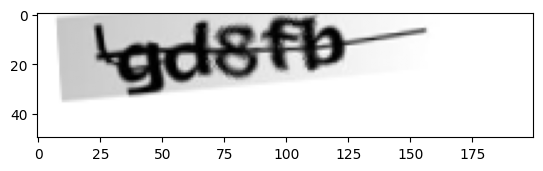

7bwm2_aug1.png


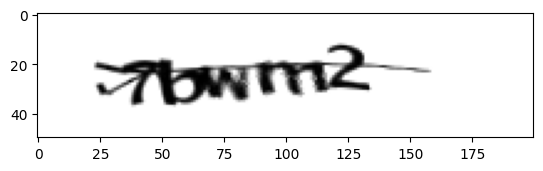

pgm2e_aug1.png


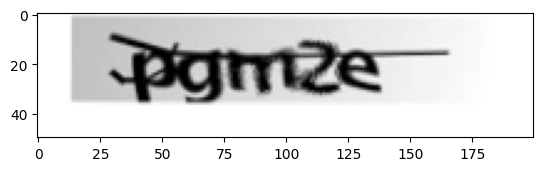

ppx77_aug1.png


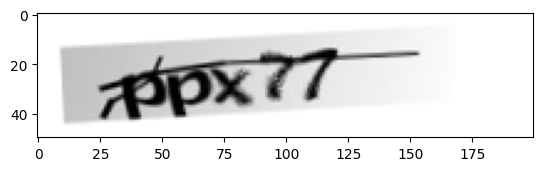

pybee_aug1.png


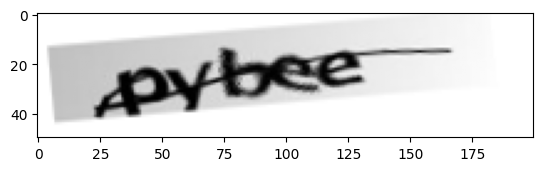

In [40]:
from PIL import ImageOps
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array

# augmented_path = '/content/drive/My Drive/Universidad/8vo/Apps avanzadas/Datasets posibles/Captchas/TrainAug'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=6,
    brightness_range=[0.4, 1.4],
    width_shift_range=0.01,
    height_shift_range=0.01,
    zoom_range=0.1
)

def pad_and_resize(image, pad=15):
    padded = ImageOps.expand(image, border=pad, fill=255)
    resized = padded.resize(IMG_SIZE)
    return resized


def augment_images(imgs_to_augment, AUGS_PER_IMAGE = 1):
  aug_imgs = []
  new_filenames = []
  for img_file in imgs_to_augment:
      label = os.path.splitext(img_file)[0]
      img_path = os.path.join(train_path, img_file)
      image = Image.open(img_path).convert("L")
      image = pad_and_resize(image)
      x = img_to_array(image)
      x = x[np.newaxis, ...]

      i = 0
      for batch in train_datagen.flow(x, batch_size=1):
          aug_img = array_to_img(batch[0])
          new_filename = f"{label}_aug{i+1}.png"
          # aug_img.save(os.path.join(augmented_path, new_filename))
          aug_img.save(os.path.join(train_path, new_filename))
          aug_imgs.append(aug_img)
          new_filenames.append(new_filename)
          i += 1
          if i >= AUGS_PER_IMAGE:
              break

  for i in range(5):
    print(new_filenames[i])
    plt.imshow(aug_imgs[i], cmap='gray')
    plt.show()

augment_images(imgs_to_augment)

Caracteres raros: {'w'}
Caracteres dominantes: {'5', 'g', 'f', 'm', 'n'}
24pew_aug1.png


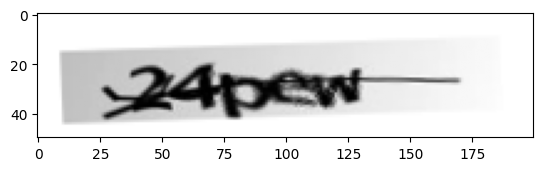

24pew_aug2.png


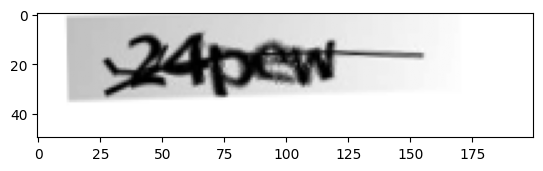

678w3_aug1.png


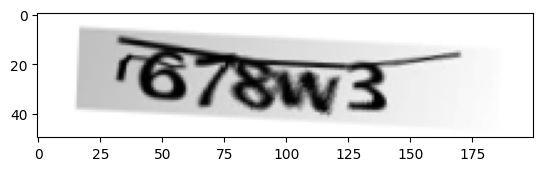

678w3_aug2.png


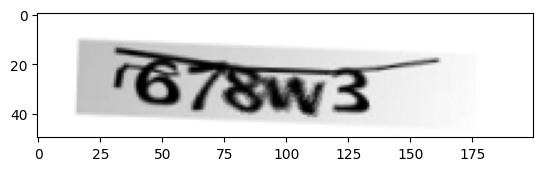

w48cw_aug1.png


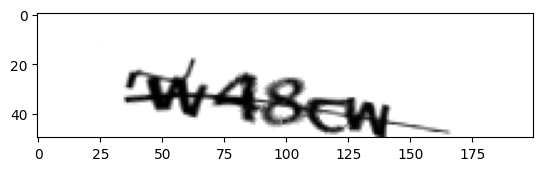

In [42]:
# Volver a balancear
imgs_to_augment = augment_captcha(train_path, y_train_aug)
augment_images(imgs_to_augment, 2)

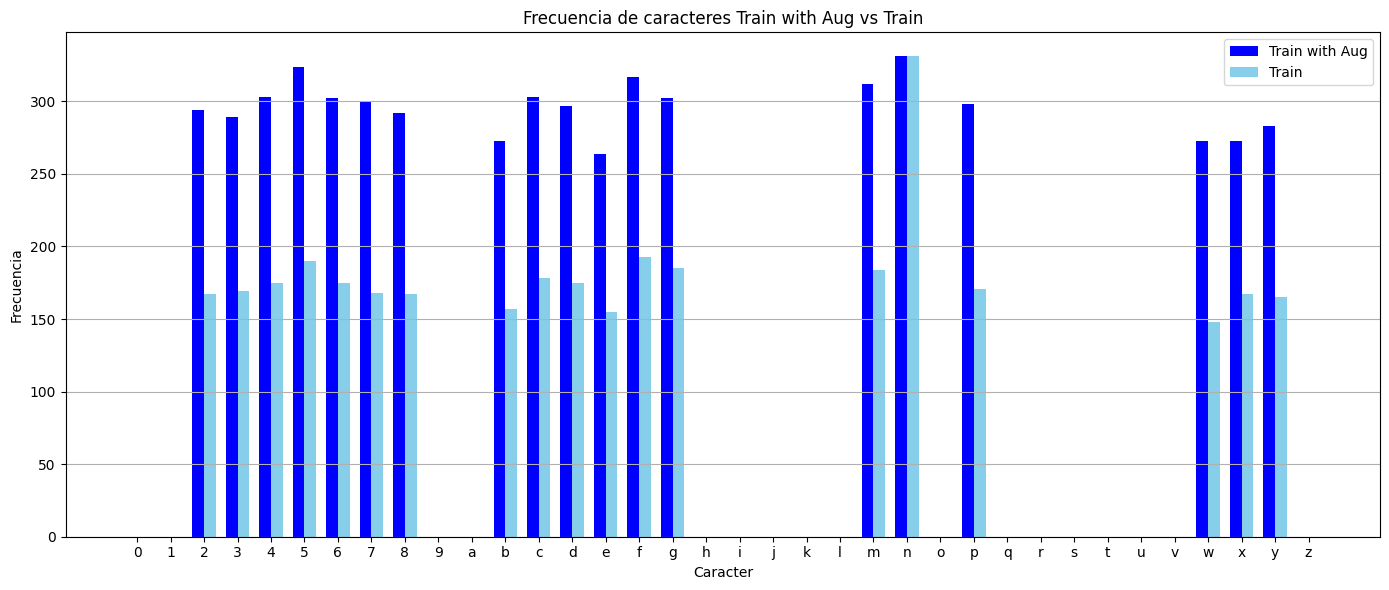

In [43]:
# Cargar el dataset de train con las augmentadas
x_train_aug, y_train_aug = load_dataset(train_path)
# Graficamos para ver las diferencias entre frecuencias
plot_char_frequencies(y_train_aug, y_train, 'Train with Aug', 'Train', 'blue', 'skyblue')

In [36]:
# BORRAR IMAGENES AUGMENTADAS
for filename in os.listdir(train_path):
    if '_aug' in filename:              # and filename.endswith('.png')
        file_path = os.path.join(train_path, filename)
        os.remove(file_path)

In [44]:
import string
from sklearn.preprocessing import LabelEncoder

# Codificar (encode) las etiquetas
all_labels = np.concatenate([y_train_aug, y_val, y_test])

unique_chars = sorted(set(char for label in all_labels for char in label))
# print("Caracteres únicos del dataset:", unique_chars)

encoder = LabelEncoder()
encoder.fit(unique_chars)

def split_and_encode_labels(y_raw, encoder):
    num_chars = 5 # Cada CAPTCHA tiene 5 caracteres
    y_splits = [[] for _ in range(num_chars)]

    for label in y_raw:
        for i, c in enumerate(label):
            y_splits[i].append(encoder.transform([c])[0])

    return np.array(y_splits).T

print("Mapeo de caracteres a números:")
for char in unique_chars:
    print(f"{char} -> {encoder.transform([char])[0]}")

y_train_encoded = split_and_encode_labels(y_train_aug, encoder)
y_val_encoded = split_and_encode_labels(y_val, encoder)
y_test_encoded = split_and_encode_labels(y_test, encoder)

Mapeo de caracteres a números:
2 -> 0
3 -> 1
4 -> 2
5 -> 3
6 -> 4
7 -> 5
8 -> 6
b -> 7
c -> 8
d -> 9
e -> 10
f -> 11
g -> 12
m -> 13
n -> 14
p -> 15
w -> 16
x -> 17
y -> 18


In [85]:
print(x_train_aug.shape)
print(y_train_encoded.shape)

# Formatear para el fit (diccionario de los chars con las labels)
y_train_dict = {
    'char1': y_train_encoded[:, 0],
    'char2': y_train_encoded[:, 1],
    'char3': y_train_encoded[:, 2],
    'char4': y_train_encoded[:, 3],
    'char5': y_train_encoded[:, 4],
}

y_val_dict = {
    'char1': y_val_encoded[:, 0],
    'char2': y_val_encoded[:, 1],
    'char3': y_val_encoded[:, 2],
    'char4': y_val_encoded[:, 3],
    'char5': y_val_encoded[:, 4],
}

y_test_dict = {
    'char1': y_test_encoded[:, 0],
    'char2': y_test_encoded[:, 1],
    'char3': y_test_encoded[:, 2],
    'char4': y_test_encoded[:, 3],
    'char5': y_test_encoded[:, 4],
}


(1126, 50, 200, 1)
(1126, 5)


In [106]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def get_model_deep(input_shape):
    input_tensor = Input(shape=input_shape)

    x = Conv2D(16, kernel_size=3, activation="relu", padding='same')(input_tensor)
    x = Conv2D(32, kernel_size=3, activation="relu", padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)

    # Define the five output layers
    output1 = Dense(19, activation='softmax', name='char1')(x)
    output2 = Dense(19, activation='softmax', name='char2')(x)
    output3 = Dense(19, activation='softmax', name='char3')(x)
    output4 = Dense(19, activation='softmax', name='char4')(x)
    output5 = Dense(19, activation='softmax', name='char5')(x)

    # Create the model with one input and five outputs
    model = Model(inputs=input_tensor, outputs=[output1, output2, output3, output4, output5])

    return model

def compile_model_deep(model):
  model.compile(optimizer= Adam(learning_rate=0.001),
                loss = "sparse_categorical_crossentropy",
                metrics=['accuracy'] * 5)

In [107]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_path = '/content/drive/My Drive/Universidad/8vo/Apps avanzadas/Datasets posibles/Captchas/Model'
checkpoint_path = os.path.join(model_path, '.weights.h5')
checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                             save_freq = "epoch",
                             save_weights_only = True,
                             verbose = 1)

In [108]:
model = get_model_deep(x_train_aug[0].shape)
model.summary()
compile_model_deep(model)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 50, 200,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 50, 200,   │        160 │ input_layer_8[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 50, 200,   │      4,640 │ conv2d_16[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 25, 100,   │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 25, 100,   │          0 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 80000)     │          0 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │  5,120,064 │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char1 (Dense)       │ (None, 19)        │      1,235 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char2 (Dense)       │ (None, 19)        │      1,235 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char3 (Dense)       │ (None, 19)        │      1,235 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char4 (Dense)       │ (None, 19)        │      1,235 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char5 (Dense)       │ (None, 19)        │      1,235 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,131,039 (19.57 MB)

 Trainable params: 5,131,039 (19.57 MB)

 Non-trainable params: 0 (0.00 B)

In [109]:
history = model.fit(x_train_aug, y_train_dict, epochs=20, batch_size=32, validation_data=(x_val, y_val_dict), callbacks = [checkpoint])

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - char1_accuracy: 0.0404 - char1_loss: 3.1218 - char2_accuracy: 0.0681 - char2_loss: 3.4313 - char3_accuracy: 0.0516 - char3_loss: 3.0744 - char4_accuracy: 0.0490 - char4_loss: 3.1646 - char5_accuracy: 0.0686 - char5_loss: 3.1671 - loss: 15.9596
Epoch 1: saving model to /content/drive/My Drive/Universidad/8vo/Apps avanzadas/Datasets posibles/Captchas/Model/.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 25s 563ms/step - char1_accuracy: 0.0407 - char1_loss: 3.1186 - char2_accuracy: 0.0678 - char2_loss: 3.4225 - char3_accuracy: 0.0517 - char3_loss: 3.0722 - char4_accuracy: 0.0489 - char4_loss: 3.1607 - char5_accuracy: 0.0682 - char5_loss: 3.1632 - loss: 15.9377 - val_char1_accuracy: 0.0234 - val_char1_loss: 2.9449 - val_char2_accuracy: 0.0760 - val_char2_loss: 2.9430 - val_char3_accuracy: 0.0351 - val_char3_loss: 2.9449 - val_char4_accuracy: 0.0643 - val_char4_loss: 2.9442 - val_char5_accuracy: 0.0994 - val_char5_loss: 2.9436 - val_loss: 14.7212

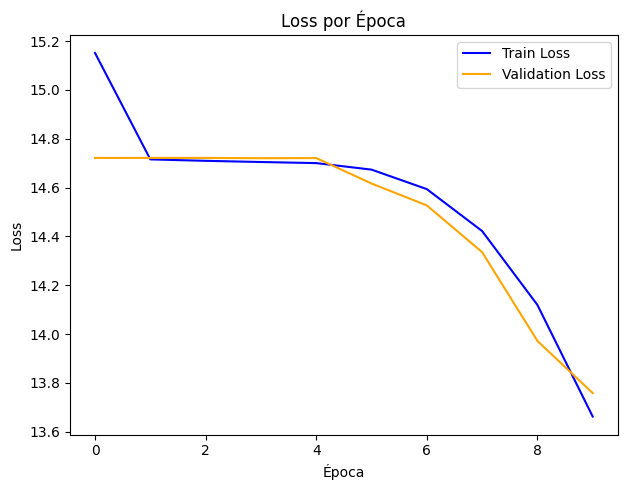

In [111]:
# Graficar pérdida (loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

# Si usas accuracy:
if 'accuracy' in history.history:
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Accuracy por Época')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()


In [81]:
# Predicciones de validation
def predict(model, imgs, labels):
  predictions = model.predict(imgs)
  decoded_predictions = []
  for i in range(predictions[0].shape[0]):
      chars = [encoder.classes_[np.argmax(pred[i])] for pred in predictions]
      decoded_predictions.append(''.join(chars))

  for i in range(5):
      random_index = random.randint(0, len(imgs) - 1)
      print(f"Predicción: {decoded_predictions[random_index]} | Real: {''.join([encoder.classes_[c] for c in labels[random_index]])}")
      plt.imshow(imgs[random_index], cmap='gray')
      plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 299ms/step
Predicción: n6wbg | Real: n5wbg


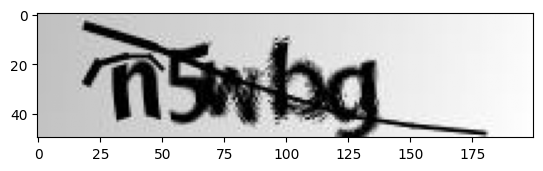

Predicción: 7625m | Real: 76353


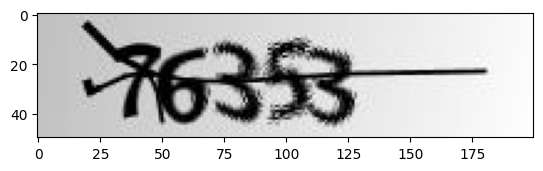

Predicción: 537mf | Real: 537nf


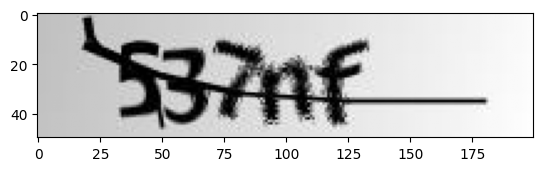

Predicción: ewmpw | Real: cwgyx


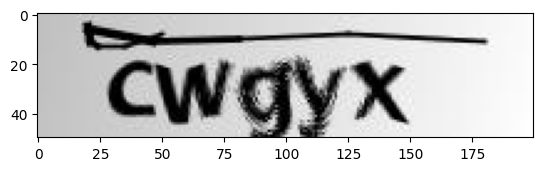

Predicción: 2w8d5 | Real: 2wx73


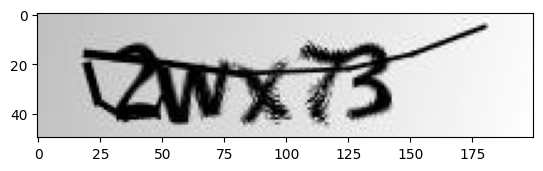

In [82]:
predict(model, x_val, y_val_encoded)

In [83]:
def evaluate_model(model, scaled_test_images, test_labels):
    results = model.evaluate(scaled_test_images, test_labels)
    print("Results: \n", results)
    total_loss = results[0]
    accuracy_char1 = results[6]
    return (total_loss, accuracy_char1)

In [86]:
test_loss, test_accuracy = evaluate_model(model, x_test, y_test_dict)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - char1_accuracy: 0.7784 - char1_loss: 1.1763 - char2_accuracy: 0.7285 - char2_loss: 1.5567 - char3_accuracy: 0.4820 - char3_loss: 4.5639 - char4_accuracy: 0.4264 - char4_loss: 6.0934 - char5_accuracy: 0.4415 - char5_loss: 4.9018 - loss: 18.0017
Results: 
 [18.536415100097656, 1.2961136102676392, 1.9138644933700562, 4.9973626136779785, 6.049744606018066, 5.150839805603027, 0.7910447716712952, 0.7388059496879578, 0.5149253606796265, 0.43283581733703613, 0.44029849767684937]
Test loss: 18.536415100097656
Test accuracy: 0.7910447716712952
